In [13]:
# 
root = "/home/shi/WorkSpace/projects/scMultiNet_Data/"
feature_locs = [
    "/cls0.pkl",
    "/cls1.pkl",
    "/cls2.pkl",
    "/cls3.pkl",
    "/cls4.pkl",
]
#/home/shi/WorkSpace/projects/scMultiNet_Data/Step_1_data/Dataset_cook_removed/TrVal_dataset_Ground_truth.pkl
raw_data_loc = root + "/Step_1_data/Dataset_cook_removed/TrVal_dataset_Ground_truth.pkl"
code_loc = "/home/shi/WorkSpace/projects/scMultiNet_workspace/"

save_folder = root + "/Step_4_data/"

ckpt_folder = root+"/Step_2_data/Cook/regression/ckpt/model_d0.3_0.629.ckpt"
ckpt_folder_cls = root + "/Step_2_data/Cook/classification/ckpt/model_0.9019531292560845.ckpt"
train_root = root + "/Step_1_data/Dataset_cook_removed/train/" #/home/shi/WorkSpace/projects/scMultiNet_Data/Step_1_data/Dataset_cook_removed/train

cls_nb = 5

In [14]:
import sys
sys.path.append(code_loc)

import dill
with open(raw_data_loc, "rb") as f:
    [trainset,valset,_,label_dict] = dill.load(f)


In [15]:
trainset.label

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [1],
        [1]])

In [16]:
print(label_dict)

{'8h_rm': 0, '1d_rm': 1, '3d_rm': 2}


In [17]:
# load model and calc features
import torch
import torch.nn.functional as F
import sys
DIM = 128


import torch.nn as nn
class FuseNet(nn.Module):
    def __init__(self,in_dim=128*5, dropout = 0., h_dim = 128, out_dim = 1, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        if out_key == "fc1":
            return x

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        if out_key == "fc2":
            return x
        x = self.fc3(x)
        if out_key == "all":
            return x
        else:
            raise ValueError("out_key must be one of 'fc1', 'fc2', 'all'")

class FuseNet(nn.Module):
    def __init__(self,in_dim=128*5, dropout = 0., h_dim = 128, out_dim = 1, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=1, bias=True)
        self.act2 = nn.ReLU()

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act2(x)
        return x

# 从文件夹中读取所有类的feature matrix
import pickle
import numpy as np


read_list = ["cls0","cls1","cls2","cls3","cls4"]
#-->train
train_feat_list = []
for i in range(len(read_list)):
    with open(train_root+read_list[i]+".pkl","rb") as f:
        [feat,label] = pickle.load(f)
        train_feat_list.append(feat)
train_label = label
print(len(train_feat_list),train_feat_list[0].shape,train_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
train_feat = np.concatenate(train_feat_list,axis=1) 
train_feat = torch.from_numpy(train_feat).float()
train_label = torch.from_numpy(train_label).long() 
# label from [sample_nb,1] -> [sample_nb,class_nb]
#train_label = torch.zeros(train_label.shape[0],cls_nb).scatter_(1,train_label,1)
print(train_feat.shape,train_label.shape)

# get Dataset and DataLoader
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(train_feat,train_label)

trainloader = DataLoader(trainset,batch_size=DIM,shuffle=False)


# get model
model = FuseNet(in_dim=DIM*5, dropout = 0., h_dim = DIM, out_dim = 1, )


# load model
model.load_state_dict(torch.load(ckpt_folder))

# get features
model.eval()
feat_layer = "fc1"
all_feat = []
all_label = []
all_pred = []
all_prob = []
with torch.no_grad():
    for data in trainloader:
        inputs,label = data
        feat = model(inputs,out_key=feat_layer)
        all_feat.append(feat)
        all_label.append(label)
        pred = model(inputs,out_key="all")
        prob = pred#F.softmax(pred,dim=1)
        all_prob.append(prob)

embedding = torch.cat(all_feat,dim=0).detach().numpy()
labels = torch.cat(all_label,dim=0).detach().numpy()
prob = torch.cat(all_prob,dim=0).detach().numpy()
print(embedding.shape,labels.shape,prob.shape)

5 (1732, 128) (1732, 1)
torch.Size([1732, 640]) torch.Size([1732, 1])
(1732, 1) (1732, 1) (1732, 1)


In [18]:
import sys
sys.path.append(code_loc)
import scLLM

# 数据集读取
import dill
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [dataset_1,dataset_2,_,_] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(dataset_1))

trainset size:  1732


In [19]:
prob.shape,len(dataset_1.sample_id)

((1732, 1), 1732)

In [20]:
# export to csv

data_dict = {
    "sample_id": dataset_1.sample_id,
    "pred_labels": prob.squeeze(),
    "true_labels": labels.squeeze(),
    "tissue_type": dataset_1.tissue_type,
}
import pandas as pd
df = pd.DataFrame(data_dict)

#df.to_csv(save_folder+"/cook_removed_pred_score.csv",index=False)

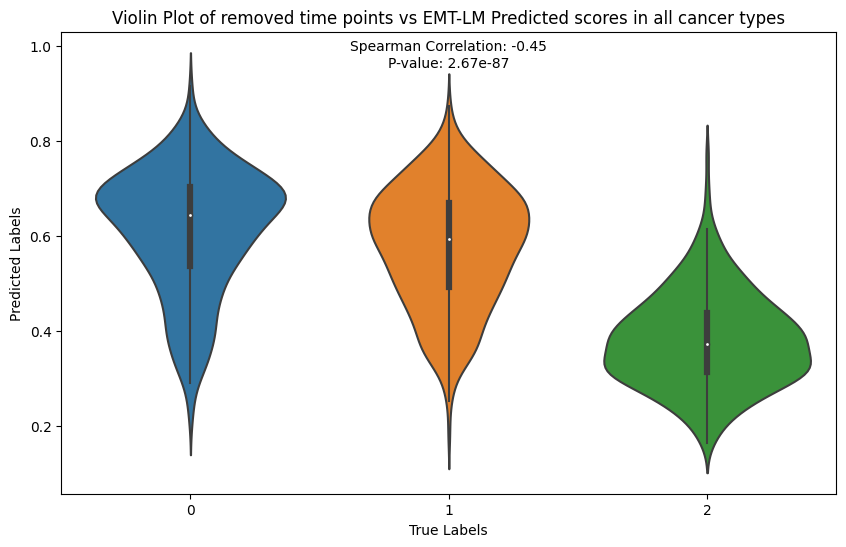

Spearman Correlation: -0.45046814997020396
P-value: 2.6707440042115266e-87


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# 绘制violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='true_labels', y='pred_labels', data=df)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Violin Plot of removed time points vs EMT-LM Predicted scores in all cancer types')

# 计算Spearman相关性和p值
correlation, p_value = spearmanr(df['true_labels'], df['pred_labels'])

# 在图上显示相关性和p值
plt.text(0.5, 0.95, f'Spearman Correlation: {correlation:.2f}\nP-value: {p_value:.2e}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.savefig(save_folder+"/cook_removed_allcancer_violin.pdf")
plt.show()

# 输出相关性和p值
print("Spearman Correlation:", correlation)
print("P-value:", p_value)


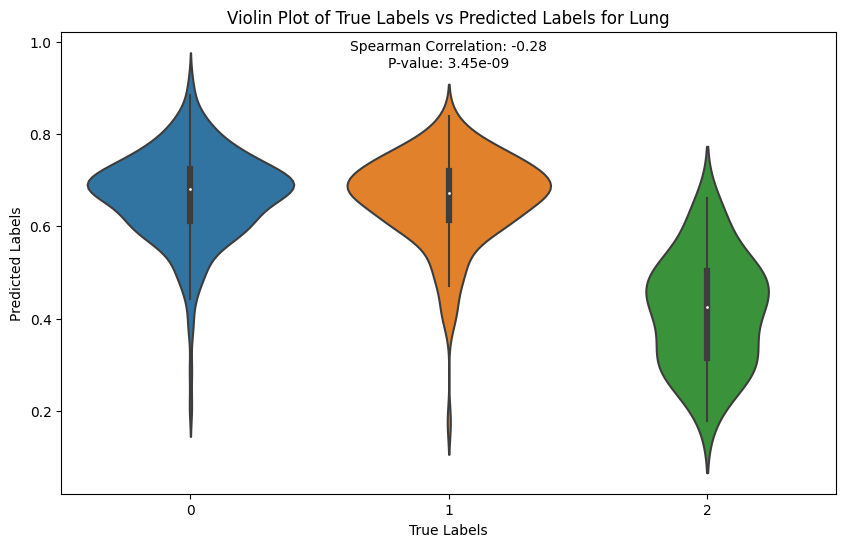

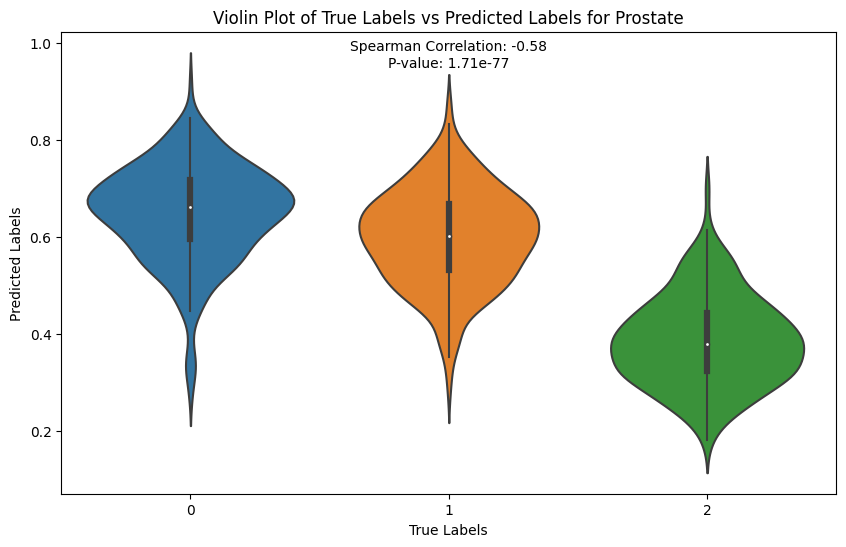

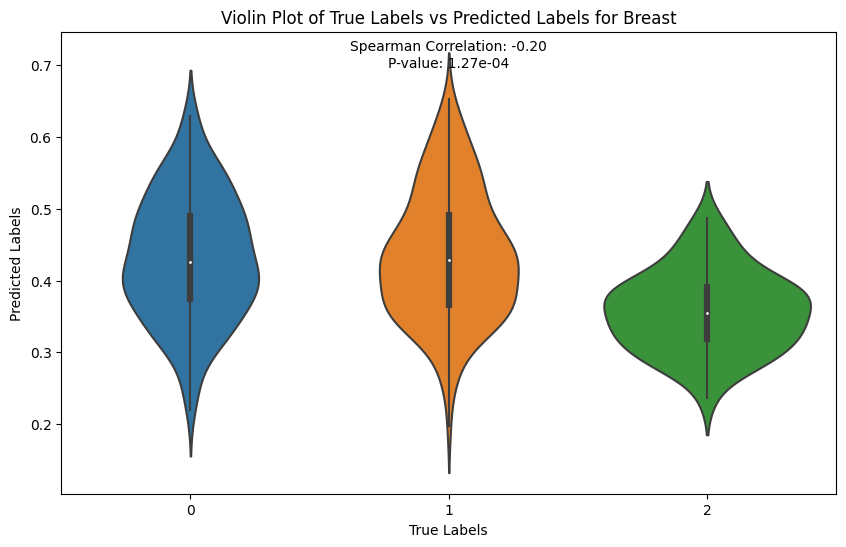

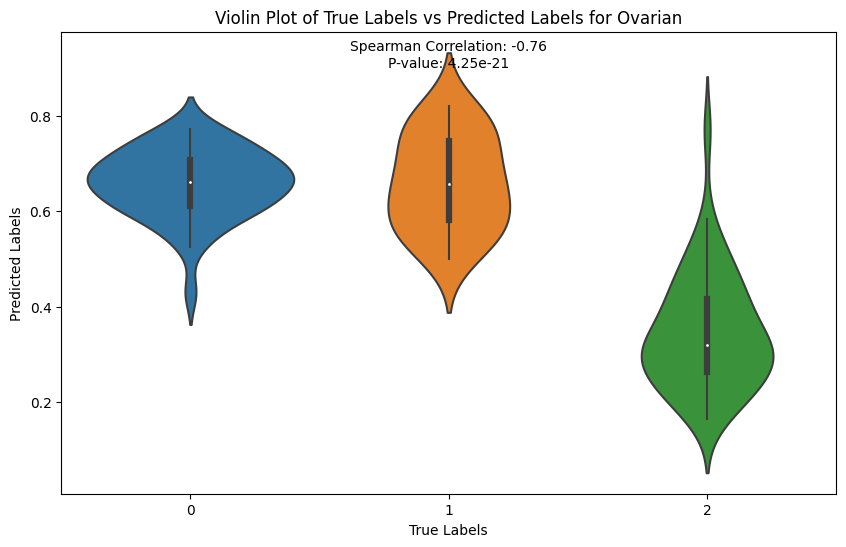

In [22]:
# Get unique tissue types
tissue_types = df['tissue_type'].unique()

# Plot violin plots for each tissue type
for tissue in tissue_types:
    tissue_df = df[df['tissue_type'] == tissue]
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='true_labels', y='pred_labels', data=tissue_df)
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title(f'Violin Plot of True Labels vs Predicted Labels for {tissue}')
    
    # Calculate Spearman correlation and p-value
    correlation, p_value = spearmanr(tissue_df['true_labels'], tissue_df['pred_labels'])
    
    # Display correlation and p-value on the plot
    plt.text(0.5, 0.95, f'Spearman Correlation: {correlation:.2f}\nP-value: {p_value:.2e}',
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig(save_folder+f"/cook_removed_{tissue}_violin.pdf")
    plt.show()


In [23]:
# load model and calc features
import torch
import torch.nn.functional as F
import sys
DIM = 128


import torch.nn as nn

class FuseNet(nn.Module):
    def __init__(self,in_dim=128*5, dropout = 0., h_dim = 128, out_dim = 1, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        if out_key == "fc1":
            return x

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        if out_key == "fc2":
            return x
        x = self.fc3(x)
        if out_key == "all":
            return x
        else:
            raise ValueError("out_key must be one of 'fc1', 'fc2', 'all'")

# 从文件夹中读取所有类的feature matrix
import pickle
import numpy as np


read_list = ["cls0","cls1","cls2","cls3","cls4"]
#-->train
train_feat_list = []
for i in range(len(read_list)):
    with open(train_root+read_list[i]+".pkl","rb") as f:
        [feat,label] = pickle.load(f)
        train_feat_list.append(feat)
train_label = label
print(len(train_feat_list),train_feat_list[0].shape,train_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
train_feat = np.concatenate(train_feat_list,axis=1) 
train_feat = torch.from_numpy(train_feat).float()
train_label = torch.from_numpy(train_label).long() 
# label from [sample_nb,1] -> [sample_nb,class_nb]
#train_label = torch.zeros(train_label.shape[0],cls_nb).scatter_(1,train_label,1)
print(train_feat.shape,train_label.shape)

# get Dataset and DataLoader
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(train_feat,train_label)

trainloader = DataLoader(trainset,batch_size=DIM,shuffle=False)


# get model
model = FuseNet(in_dim=DIM*5, dropout = 0., h_dim = DIM, out_dim = 5, )


# load model
model.load_state_dict(torch.load(ckpt_folder_cls))

# get features
model.eval()
feat_layer = "fc1"
all_feat = []
all_label = []
all_pred = []
all_prob = []
with torch.no_grad():
    for data in trainloader:
        inputs,label = data
        feat = model(inputs,out_key=feat_layer)
        all_feat.append(feat)
        all_label.append(label)
        pred = model(inputs,out_key="all")
        prob = pred#F.softmax(pred,dim=1)
        all_prob.append(prob)

embedding = torch.cat(all_feat,dim=0).detach().numpy()
labels = torch.cat(all_label,dim=0).detach().numpy()
prob = torch.cat(all_prob,dim=0).detach().numpy()
print(embedding.shape,labels.shape,prob.shape)

5 (1732, 128) (1732, 1)
torch.Size([1732, 640]) torch.Size([1732, 1])
(1732, 512) (1732, 1) (1732, 5)


In [24]:
pred = np.argmax(prob,axis=1)

In [25]:
# export to csv

data_dict = {
    "sample_id": dataset_1.sample_id,
    "pred_labels": pred.squeeze(),
    "true_labels": labels.squeeze(),
    "tissue_type": dataset_1.tissue_type,
}
import pandas as pd
df = pd.DataFrame(data_dict)

#df.to_csv(save_folder+"/cook_removed_pred_cat.csv",index=False)

In [26]:
# get label mapping
label_dict = {'3d':0, '7d':1, '1d':2, '8h':3, '0d':4}

In [28]:
# Define the mapping dictionaries
true_label_mapping = {'8h_rm': 0, '1d_rm': 1, '3d_rm': 2}
pred_label_mapping = {'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}

# Reverse the mapping dictionaries
reverse_true_label_mapping = {v: k for k, v in true_label_mapping.items()}
reverse_pred_label_mapping = {v: k for k, v in pred_label_mapping.items()}

# Map the integer values to their respective string labels
df['true_label_str'] = df['true_labels'].map(reverse_true_label_mapping)
df['pred_label_str'] = df['pred_labels'].map(reverse_pred_label_mapping)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Label Mappings Data", dataframe=data)

# Display the first few rows of the updated dataframe to verify the changes
df.head()


,sample_id,pred_labels,true_labels,tissue_type,true_label_str,pred_label_str
0,Mix1_ACTTACTAGTGCGATG-1,0,1,Lung,1d_rm,3d
1,Mix1_ATCATCTAGTAACCCT-1,0,1,Lung,1d_rm,3d
2,Mix1_CACAAACCACGGACAA-1,0,1,Lung,1d_rm,3d
3,Mix1_CCAGCGACACCAGTTA-1,0,1,Lung,1d_rm,3d
4,Mix1_GCGCAACGTCGGATCC-1,0,1,Lung,1d_rm,3d


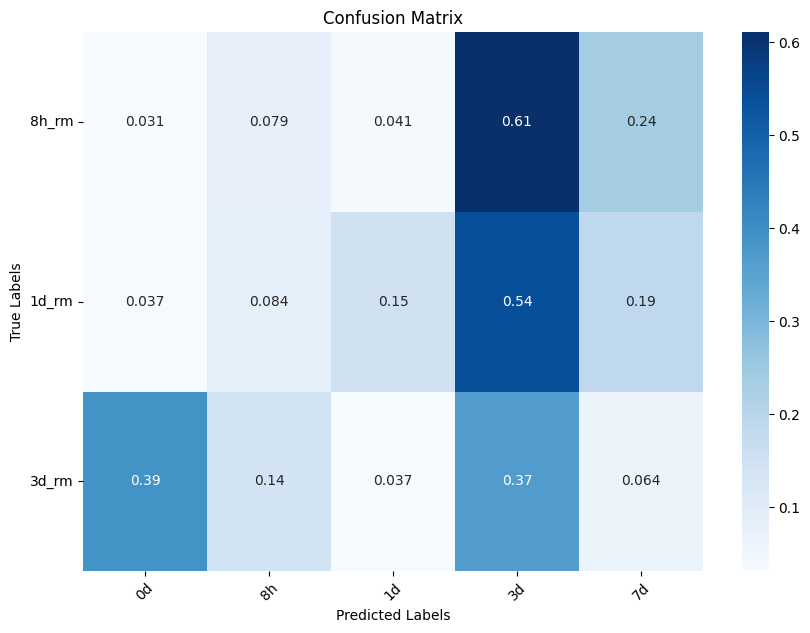

In [36]:
# Define the order for the labels
true_label_order = ['8h_rm', '1d_rm', '3d_rm']
pred_label_order = ['0d', '8h', '1d', '3d', '7d']

# Create a cross-tabulation of the true and predicted labels
cross_tab = pd.crosstab(df['true_label_str'], df['pred_label_str'])

# Reorder the cross-tabulation to match the specified label orders
cross_tab_reordered = cross_tab.reindex(index=true_label_order, columns=pred_label_order, fill_value=0)

# change number to rate
cross_tab_reordered_rate = cross_tab_reordered.div(cross_tab_reordered.sum(axis=1), axis=0)


import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cross_tab_reordered_rate, annot=True, cmap='Blues', )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig(save_folder+"/cook_removed_crosstab_matrix.pdf")
plt.show()

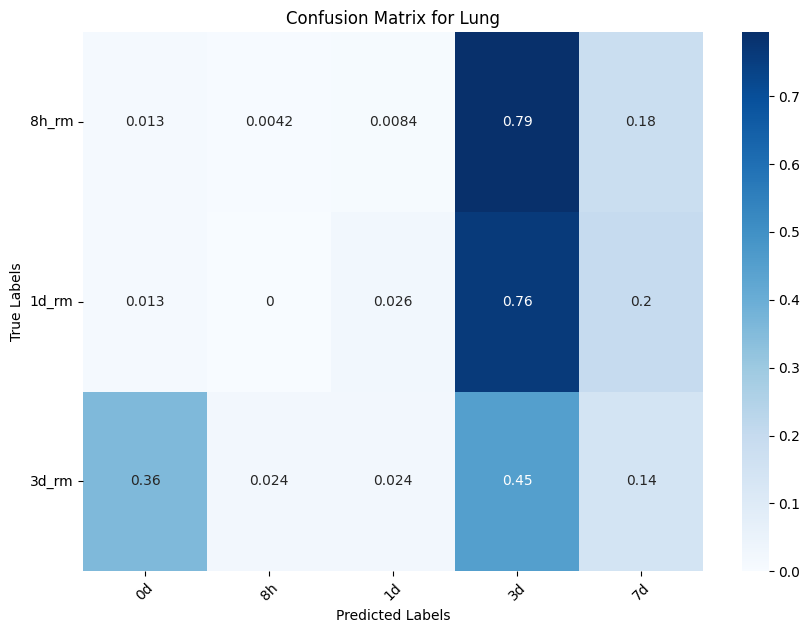

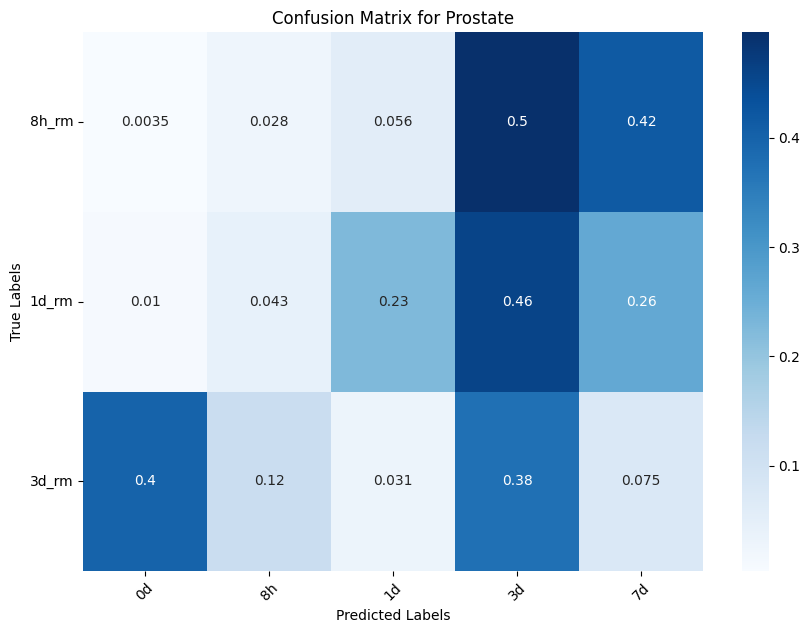

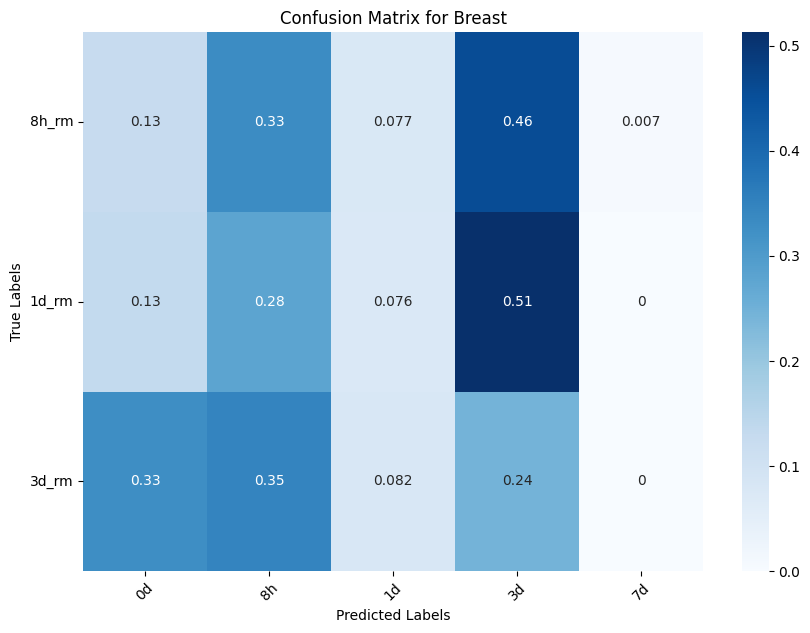

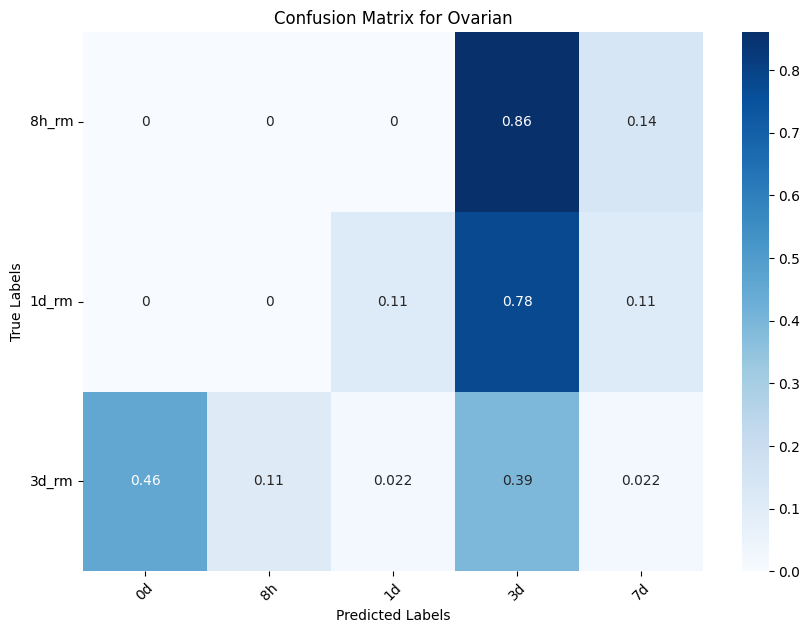

In [35]:
# Get unique tissue types
tissue_types = df['tissue_type'].unique()

# Generate and plot confusion matrices for each tissue type
for tissue in tissue_types:
    tissue_data = df[df['tissue_type'] == tissue]
    
    # Create a cross-tabulation of the true and predicted labels
    cross_tab_tissue = pd.crosstab(tissue_data['true_label_str'], tissue_data['pred_label_str'])
    
    # Reorder the cross-tabulation to match the specified label orders
    cross_tab_tissue_reordered = cross_tab_tissue.reindex(index=true_label_order, columns=pred_label_order, fill_value=0)
    
    # change number to rate
    cross_tab_tissue_reordered_rate = cross_tab_tissue_reordered.div(cross_tab_tissue_reordered.sum(axis=1), axis=0)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cross_tab_tissue_reordered_rate, annot=True,  cmap='Blues',)
    plt.title(f'Confusion Matrix for {tissue}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.savefig(save_folder+f"/cook_removed_crosstab_matrix_{tissue}.pdf")
    plt.show()


In [13]:
import pandas as pd
import pickle
import numpy as np

pkl_list = ["cls0", "cls1", "cls2", "cls3", "cls4"]  # -->train
label_dict = {'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}

# 构建reverse_label_map
reverse_label_map = {v: k for k, v in label_dict.items()}

# 读取sample_id
sample_id = dataset_1.sample_id  # 假设dataset_1是包含sample_id的DataFrame或Series

# 初始化结果DataFrame
thres_columns = [reverse_label_map[i] for i in range(len(label_dict))]
result_df_thres = pd.DataFrame(index=sample_id, columns=thres_columns)
argmax_columns = [reverse_label_map[i] for i in range(len(label_dict))]
result_df_argmax = pd.DataFrame(index=sample_id, columns=argmax_columns)

result_df_scoreout = pd.DataFrame(index=sample_id, columns=argmax_columns)

# add true labels
result_df_thres["true_labels"] = labels.squeeze()
result_df_argmax["true_labels"] = labels.squeeze()
result_df_scoreout["true_labels"] = labels.squeeze()

# add tissue type
result_df_thres["tissue_type"] = dataset_1.tissue_type
result_df_argmax["tissue_type"] = dataset_1.tissue_type
result_df_scoreout["tissue_type"] = dataset_1.tissue_type

for i in range(len(pkl_list)):
    with open(train_root + pkl_list[i] + ".pkl", "rb") as f:
        [prob, label] = pickle.load(f)

    # softmax后的概率
    # 对prob进行softmax操作
    prob_softmax = np.exp(prob) / np.sum(np.exp(prob), axis=1, keepdims=True)
    # 使用阈值0.5将prob转换为0,1表示
    binary_pred_thres = (prob[:, 1] > 0.5).astype(int)

    # 使prob
    binary_pred_argmax = prob_softmax[:, 1]
    binary_score = prob[:, 1]

    # 将结果添加到结果DataFrame中
    result_df_thres[reverse_label_map[i]] = binary_pred_thres
    result_df_argmax[reverse_label_map[i]] = binary_pred_argmax
    result_df_scoreout[reverse_label_map[i]] = binary_score


# 输出结果DataFrame
print("使用阈值0.5的结果:")
#result_df_thres.to_csv(save_folder+"/cook_removed_thres5cat_with_samples.csv")
#print("\n使用argmax的结果:")
#result_df_argmax.to_csv(save_folder+"/cook_removed_prob5cat_with_samples.csv")
print("\n输出score:")
#result_df_scoreout.to_csv(save_folder+"/cook_removed_score5cat_with_samples.csv")


使用阈值0.5的结果:

使用argmax的结果:

输出score:
